In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import numpy as np
import statsmodels.api as sm
from statsmodels import regression
import plotly.graph_objects as go
import pandas as pd

In [3]:
ibov=yf.download("^BVSP", start='2021-01-01', end='2022-01-01')['Close']
bbdc=yf.download("BBDC3.SA", start='2021-01-01', end='2022-01-01')['Close']

/tmp/ipython-input-3-3761716847.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov=yf.download("^BVSP", start='2021-01-01', end='2022-01-01')['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-3761716847.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bbdc=yf.download("BBDC3.SA", start='2021-01-01', end='2022-01-01')['Close']
[*********************100%***********************]  1 of 1 completed


In [4]:
retorno_bench=ibov.pct_change()
retorno_bbdc=bbdc.pct_change()

In [5]:
retorno_bench.dropna(inplace=True)
retorno_bbdc.dropna(inplace=True)

In [6]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=retorno_bench.index, y=retorno_bench['^BVSP'], name='IBOV'))
fig.add_trace(go.Scatter(x=retorno_bbdc.index, y=retorno_bbdc['BBDC3.SA'], name='BBDC3'))
fig.update_layout(title='Retornos Diários', template='simple_white')
fig.show()

In [7]:
x=retorno_bench.values
y=retorno_bbdc.values

In [8]:
x=sm.add_constant(x)
modelo=regression.linear_model.OLS(y,x).fit()
alfa,beta=modelo.params[0], modelo.params[1]
print(alfa, beta)

-0.00029756110306300063 1.1360855663411515


In [9]:
carteira=pd.DataFrame()
carteira['carteira']=-1*beta*retorno_bench['^BVSP']+retorno_bbdc['BBDC3.SA']

In [10]:
x=retorno_bench.values
z=carteira['carteira']

x=sm.add_constant(x)
modelo=regression.linear_model.OLS(z,x).fit()
alfa,beta=modelo.params[0], modelo.params[1]
print(alfa, beta)

-0.0002975611030630008 2.3201926491189795e-16


/tmp/ipython-input-10-354700827.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [47]:
ativos=['PETR4.SA', 'BBDC4.SA', 'ABEV3.SA', 'ITSA4.SA']
pesos = [0.25,0.25,0.25,0.25]

portfolio=yf.download(ativos, start='2015-01-01', end='2020-12-31')['Close']
bvsp=yf.download('^BVSP', start='2015-01-01', end='2020-12-31')['Close']

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


In [48]:
ret_port=portfolio.pct_change()
ret_port.dropna(inplace=True)
ret_carteira=pd.DataFrame()
ret_carteira['carteira']=(ret_port*pesos).sum(axis=1)

ret_mercado=pd.DataFrame()
ret_mercado['mercado']=bvsp.pct_change()
ret_mercado.dropna(inplace=True)

In [49]:
regressao=pd.merge(ret_mercado, ret_carteira, left_index=True, right_index=True)
regressao.dropna(inplace=True)
regressao.head()

,mercado,carteira
Date,,
2015-01-05,-0.020510,-0.024560
2015-01-06,0.010186,0.011484
2015-01-07,0.030458,0.034671
2015-01-08,0.009704,0.035098
2015-01-09,-0.022085,-0.012620


In [50]:
#Regressão Insample

x=regressao['mercado']
y=regressao['carteira']

x=sm.add_constant(x)

modelo=regression.linear_model.OLS(y,x).fit()
alfa,beta=modelo.params[0], modelo.params[1]
print(alfa, beta)

-3.595469810984026e-05 1.0905185420103012


In [51]:
#Dados Out of Sample

portfolio_out=yf.download(ativos, start='2020-01-01', end='2025-06-27')['Close']
bvsp_out=yf.download('^BVSP', start='2020-01-01', end='2025-06-27')['Close']

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
ret_port_out=portfolio_out.pct_change()
ret_carteira_out=pd.DataFrame()
ret_carteira_out['carteira_out']=(ret_port_out*pesos).sum(axis=1)
ret_carteira_out.dropna(inplace=True)

ret_mercado_out=pd.DataFrame()
ret_mercado_out['mercado_out']=bvsp_out.pct_change()
ret_mercado_out.dropna(inplace=True)

In [53]:
regressao_out=pd.merge(ret_mercado_out, ret_carteira_out, how='inner', left_index=True, right_index=True)
regressao_out.head()

,mercado_out,carteira_out
Date,,
2020-01-03,-0.007304,-0.009084
2020-01-06,-0.007043,-0.000852
2020-01-07,-0.001848,-0.008157
2020-01-08,-0.003557,-0.010367
2020-01-09,-0.002581,-0.011718


In [54]:
carteira_hedge=pd.DataFrame()

carteira_hedge['hedge']=(1+(-1*beta*ret_mercado_out['mercado_out']+ret_carteira_out['carteira_out'])).cumprod()
carteira_hedge['sem_hedge']=(1+ret_carteira_out['carteira_out']).cumprod()
carteira_hedge.dropna(inplace=True)
carteira_hedge.head()

,hedge,sem_hedge
Date,,
2020-01-03,0.998881,0.990916
2020-01-06,1.005702,0.990072
2020-01-07,0.999525,0.981996
2020-01-08,0.993040,0.971816
2020-01-09,0.984198,0.960428


<Axes: xlabel='Date'>

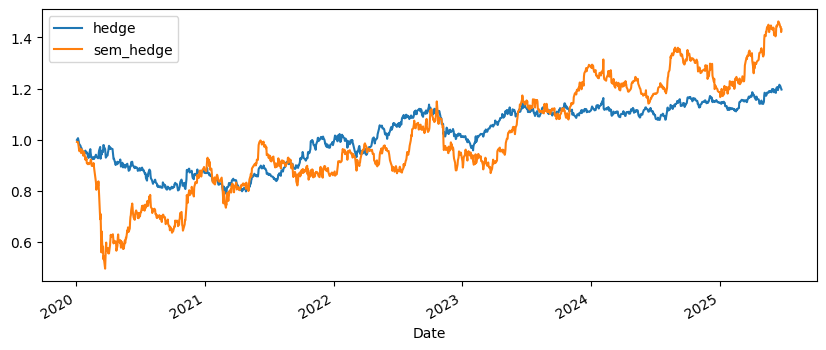

In [57]:
carteira_hedge.plot(figsize=(10,4))